In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Flatten, Dense, Dropout, MaxPooling2D, Conv2D,BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import os
import numpy as np
import PIL

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
height = 224
width = 224
channels = 3
img_shape = (height, width, channels)
img_size = (height, width)

In [3]:
TRAINING_DIR = "/kaggle/input/dataset-food-indonesia-42/Train"
VALIDATION_DIR = "/kaggle/input/dataset-food-indonesia-42/Val"
TEST_DIR = "/kaggle/input/dataset-food-indonesia-42/Test"

In [4]:
training_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.2,
    rotation_range=20,
    validation_split=0.2  # tambahkan koma di sini
)

train_generator = training_datagen.flow_from_directory(
    TRAINING_DIR,
    target_size=img_size,
    class_mode='categorical',  # ganti 'labels' menjadi 'class_mode'
    subset='training',  # tambahkan ini untuk data pelatihan
    shuffle=True,
    seed=123
)

Found 8064 images belonging to 42 classes.


In [5]:
validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                                   class_mode='categorical',
                                                                   color_mode='rgb',
                                                                   shuffle=False,
                                                                   target_size=img_size,
                                                                   seed=123)

# Mendapatkan nama kelas
labels = train_generator.class_indices
print(labels)

# Simpan label ke dalam file
with open('food_label.txt', 'w') as f:
    for food_class, index in labels.items():
        f.write(f'{food_class}: {index}\n')

Found 1260 images belonging to 42 classes.
{'Ayam_Crispy': 0, 'Ayam_Kecap': 1, 'Ayam_Serundeng': 2, 'Bakso': 3, 'Brownies': 4, 'Bubur_Ayam': 5, 'Capcay': 6, 'Cumi_Bakar': 7, 'Cumi_Hitam': 8, 'Cumi_Rica': 9, 'Dimsum_Ikan': 10, 'Garang_Asem': 11, 'Ikan_Bakar': 12, 'Ikan_Goreng': 13, 'Kentang_Balado': 14, 'Kue_Bolu': 15, 'Nasi_Bakar': 16, 'Nasi_Goreng': 17, 'Nasi_Kuning': 18, 'Nasi_Merah': 19, 'Nasi_Rames': 20, 'Opor_Ayam': 21, 'Pancake': 22, 'Pecel': 23, 'Pepes_Ikan': 24, 'Perkedel_Kentang': 25, 'Pukis': 26, 'Rawon': 27, 'Rendang': 28, 'Salad_Sayur': 29, 'Sate_Ayam': 30, 'Sate_Kambing': 31, 'Sayur_Asem': 32, 'Sayur_Sop': 33, 'Soto_Ayam': 34, 'Telur_Balado': 35, 'Telur_Dadar': 36, 'Tumis_Kacang_Panjang_Tahu': 37, 'Tumis_Kangkung': 38, 'Tumis_Terong': 39, 'Udang_Asam_Manis': 40, 'Udang_Goreng_Tepung': 41}


In [6]:
# ImageDataGenerator untuk data uji
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=img_size,
    class_mode='categorical',  # ganti 'labels' menjadi 'class_mode'
    shuffle=False
)

Found 1260 images belonging to 42 classes.


In [7]:
test_labels = test_generator.class_indices
print(test_labels)

{'Ayam_Crispy': 0, 'Ayam_Kecap': 1, 'Ayam_Serundeng': 2, 'Bakso': 3, 'Brownies': 4, 'Bubur_Ayam': 5, 'Capcay': 6, 'Cumi_Bakar': 7, 'Cumi_Hitam': 8, 'Cumi_Rica': 9, 'Dimsum_Ikan': 10, 'Garang_Asem': 11, 'Ikan_Bakar': 12, 'Ikan_Goreng': 13, 'Kentang_Balado': 14, 'Kue_Bolu': 15, 'Nasi_Bakar': 16, 'Nasi_Goreng': 17, 'Nasi_Kuning': 18, 'Nasi_Merah': 19, 'Nasi_Rames': 20, 'Opor_Ayam': 21, 'Pancake': 22, 'Pecel': 23, 'Pepes_Ikan': 24, 'Perkedel_Kentang': 25, 'Pukis': 26, 'Rawon': 27, 'Rendang': 28, 'Salad_Sayur': 29, 'Sate_Ayam': 30, 'Sate_Kambing': 31, 'Sayur_Asem': 32, 'Sayur_Sop': 33, 'Soto_Ayam': 34, 'Telur_Balado': 35, 'Telur_Dadar': 36, 'Tumis_Kacang_Panjang_Tahu': 37, 'Tumis_Kangkung': 38, 'Tumis_Terong': 39, 'Udang_Asam_Manis': 40, 'Udang_Goreng_Tepung': 41}


In [8]:
for image_batch, labels_batch in train_generator:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 224, 224, 3)
(32, 42)


In [9]:
# Callback EarlyStopping untuk menghentikan pelatihan jika val_loss tidak berkurang
early_stopping_callback = EarlyStopping(monitor='val_loss', mode='min', patience=10)

In [10]:
# Model menggunakan pre-trained MobileNet
base_model = Xception(input_shape=img_shape, include_top=False, weights='imagenet')

# Membuat model sederhana di atas pre-trained MobileNet
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(42, activation='softmax')
])

83683744/83683744 [==============================] - 3s 0us/step


In [11]:
# Mengatur model untuk pelatihan
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


# Menampilkan ringkasan model
model.summary()

# Pelatihan model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    batch_size=32,
    callbacks=[early_stopping_callback]
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 batch_normalization_4 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 42)                1

/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


252/252 [==============================] - 241s 816ms/step - loss: 2.8912 - accuracy: 0.2685 - val_loss: 2.3734 - val_accuracy: 0.6190
Epoch 2/20
252/252 [==============================] - 159s 628ms/step - loss: 1.3237 - accuracy: 0.6243 - val_loss: 0.7584 - val_accuracy: 0.7841
Epoch 3/20
252/252 [==============================] - 157s 624ms/step - loss: 0.8686 - accuracy: 0.7500 - val_loss: 0.5734 - val_accuracy: 0.8246
Epoch 4/20
252/252 [==============================] - 158s 625ms/step - loss: 0.6151 - accuracy: 0.8219 - val_loss: 0.5858 - val_accuracy: 0.8135
Epoch 5/20
252/252 [==============================] - 158s 624ms/step - loss: 0.4425 - accuracy: 0.8671 - val_loss: 0.5087 - val_accuracy: 0.8468
Epoch 6/20
252/252 [==============================] - 157s 621ms/step - loss: 0.3468 - accuracy: 0.8968 - val_loss: 0.4903 - val_accuracy: 0.8540
Epoch 7/20
252/252 [==============================] - 157s 623ms/step - loss: 0.2727 - accuracy: 0.9180 - val_loss: 0.4967 - val_accura

Akurasi pelatihan: 0.9799107313156128
Loss pelatihan: 0.07020631432533264
Akurasi validasi: 0.8730158805847168
Loss validasi: 0.5359578728675842


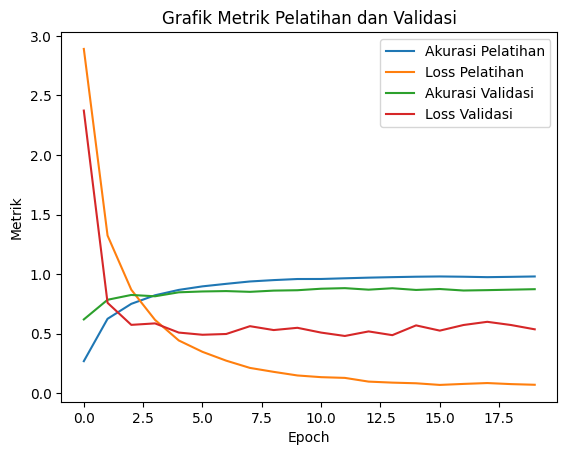

In [12]:
# Cetak metrik pelatihan dan validasi
print("Akurasi pelatihan:", history.history['accuracy'][-1])
print("Loss pelatihan:", history.history['loss'][-1])
print("Akurasi validasi:", history.history['val_accuracy'][-1])
print("Loss validasi:", history.history['val_loss'][-1])

# Plot grafik metrik pelatihan
plt.plot(history.history['accuracy'], label='Akurasi Pelatihan')
plt.plot(history.history['loss'], label='Loss Pelatihan')

# Plot grafik metrik validasi
plt.plot(history.history['val_accuracy'], label='Akurasi Validasi')
plt.plot(history.history['val_loss'], label='Loss Validasi')

# Tambahkan label dan judul
plt.xlabel('Epoch')
plt.ylabel('Metrik')
plt.title('Grafik Metrik Pelatihan dan Validasi')
plt.legend()

# Tampilkan grafik
plt.show()

In [13]:
# Evaluasi model pada data uji
test_loss, test_acc = model.evaluate(test_generator)
print(f'\nTest Accuracy: {test_acc}, Test Loss: {test_loss}')

40/40 [==============================] - 17s 439ms/step - loss: 0.5665 - accuracy: 0.8730

Test Accuracy: 0.8730158805847168, Test Loss: 0.5664617419242859


In [14]:
#Save the model
#!mkdir -p saved_model
model.save('saved_model/val_acc')

# Convert the model
path = '/kaggle/working/saved_model/val_acc'
converter = tf.lite.TFLiteConverter.from_saved_model(path) # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.
with open('food_val.tflite', 'wb') as f:
  f.write(tflite_model)

40/40 [==============================] - 11s 260ms/step


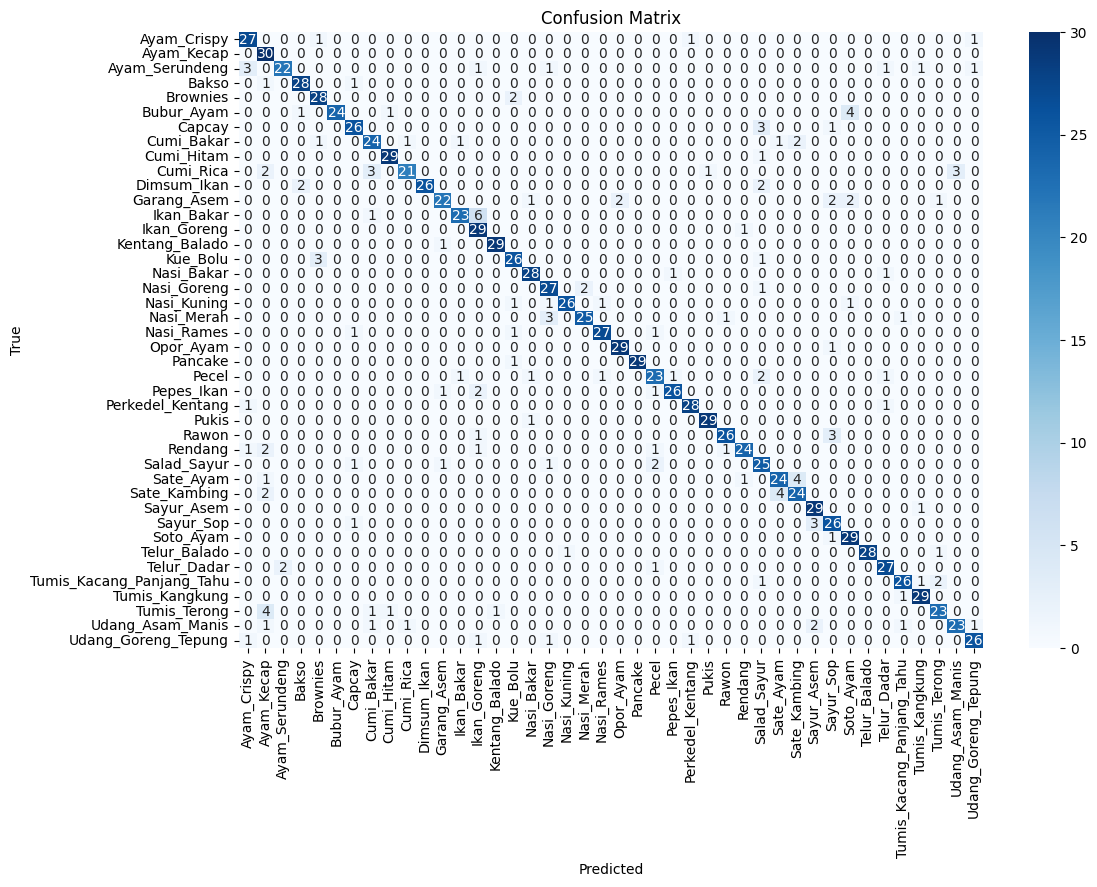

In [15]:
# Prediksi kelas dari data uji
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Ambil label yang sebenarnya
y_true = test_generator.classes

# Dapatkan nama kelas
class_names = list(test_generator.class_indices.keys())

# Hitung confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix menggunakan seaborn
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [16]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

# Mendapatkan prediksi dari model untuk data validasi
y_pred = model.predict(test_generator)

# Mengubah hasil prediksi menjadi kelas yang benar-benar diprediksi (0 atau 1)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

# Menghitung precision, recall, dan f1-score
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

# Menampilkan classification report
print('Classification Report:')
print(classification_report(y_true, y_pred_classes))

40/40 [==============================] - 11s 267ms/step
Precision: 0.8807194430609908
Recall: 0.873015873015873
F1 Score: 0.8732608064926604
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.90      0.86        30
           1       0.70      1.00      0.82        30
           2       0.92      0.73      0.81        30
           3       0.90      0.93      0.92        30
           4       0.85      0.93      0.89        30
           5       1.00      0.80      0.89        30
           6       0.87      0.87      0.87        30
           7       0.80      0.80      0.80        30
           8       0.94      0.97      0.95        30
           9       0.91      0.70      0.79        30
          10       1.00      0.87      0.93        30
          11       0.88      0.73      0.80        30
          12       0.92      0.77      0.84        30
          13       0.71      0.97      0.82        30
          14       0.97  

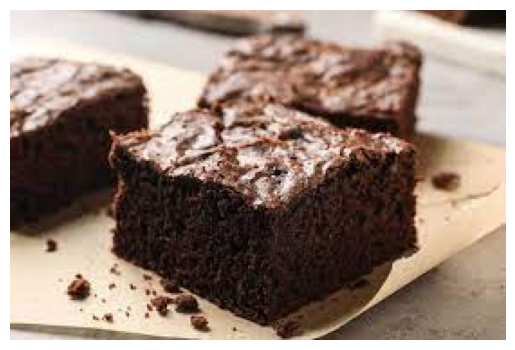

1/1 [==============================] - 1s 1s/step
Prediksi: Telur_Dadar
Skor Kategori: 1.0


In [17]:
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import urllib
from PIL import Image

# URL gambar yang ingin diuji
image_url = "data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAoHCBYWFRgWFRYYGRgaGhwcHBoaGBwYGhoZGhgaHhgZGhoeIS4lHB4rIRgYJzgmKy8xNTU1GiQ7QDs0Py40NTEBDAwMEA8QHxISHjQrJCs0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NP/AABEIALcBEwMBIgACEQEDEQH/xAAcAAAABwEBAAAAAAAAAAAAAAAAAQIDBAUGBwj/xABAEAACAQIEBAQEBAQDBgcAAAABAhEAAwQSITEFQVFhBiJxgRMykaFCscHwBxRS0SNy4RYzgpLC8RUXJENistL/xAAYAQADAQEAAAAAAAAAAAAAAAAAAQIDBP/EACMRAAICAwACAgIDAAAAAAAAAAABAhESITFBUQNhE3EiMpH/2gAMAwEAAhEDEQA/AOrRRGnstJ+HSKI7LSSlSClERQBFa0OlMPhFPKpzU21KgspsTwVG5VSY7wxPykitmaQwpjOYcQ8O3QDBmsvf4TiFb5Jrub2geVR34eh5ClQrOL21vJ8yNUq1xEj5pHrXV7nCUPKqrGeGLb/hFKilIyWG4rpo1Pnjbj5WqTifBcfISKpsV4bxCfKZqHEtSZOPiW5OutSrfimNwayV/CYlN0n0qM2IcfMjfSliGbOh4bxQraGrrD44OJBrluCdydEb6VqsG1wJ5V1pYlZP0bfDXF5mabvYtAYBFcwxWIxRc5WI12FRr384upb60/AvJ1uxiFbY1INYjwZceJuNzrbhgatGcuhAUcUYpUUxDRWrXAqAKrwKkhoFDAsHRTvUHE8LR91H0pK3z1p5MTU2FNGa4j4MtPJCweo0rI8W8F3Ekocw6HeusLiRRFlbeKlxT4aR+SSOA3OHXEaXQr6j9apeL4oHQV6NxPC7biCBWYx/8PsO5JyCe2lKMWmVL5E1RwFqQRXYsT/DJPwyKgP/AA5jYmtbMWjleU0K6b/5eN1NCjIVHc8tFFQbvEV5Gov/AIg07ihtDUWW5WkFKosTxxkGwY9AaewnErrCWtxPKeXepseLLNrNMtZNIfiir8wIpf8A4ihEiT7UZBi/Q0yGm2qSuNtt+IU5CkSCIp5BRX5qPNUtsMDtTD4U8qeSFiMlqKaU1lhyps0WKg4pD2QeVLzUJoGQ7mBQ7gVWsmGDwxSfartwrSpMTWU4zwS2klZLtOs1MnRpGNlvxCzZVM6hdKz+FxT3JW0o9YgCqtOHXVU578LyE05hrd9JNpl9zWbabNkmkWuDwq23yOQXY0vi+FRCGuMMvSsoMViFu5nhm6zUjG4j4oCuCzfai0KiSnEUZ8llvpVlgcZdRiGbNVTgMCwZRatgHmxrX4LhxthnuQSf3FKn4ZVryiFa4+6tDqYq0bjtsDUxUfHPbCSEzHoBNZLHOzgeQqB1qrkvJOMZeDcWuO2j+IUjEcftAHzge9c7uYrKpINVDYkuwB2nftRk2H44rZ1Gzj84OV9aq04/dtuQ3mAPKs3hlcuFtMcoGsVH4groxZWLNzFTkPFHU+FcXS8sjQ9KsA/SuYeAb73LrgzpE9K6G1thtWi2jCSp6LBbxp5MT1qoF8jcU+mIBpkFqt4GlZVPSqwP3ow5osKLD4S0KgZ260VFjpGbx/x7hCKMiH8fMUOH8GhvPduP9hUu9ihdc2rctl3YDyj3q4VGRJzL3oqzS6EYbBIp0UT1O9TLKhBqZqIMWpEqQxPTaqbiXFVRv8QkDkBqDTtIVNj/ABbHB2ygwi6ljz7VGxPiFEAVCGnoRpUNcUl8FQhAO0iJpWE4BbVc7gCNYqbvhVJdM3xLjF0vFlMwnUxVlhuK4kJlcZVPMbim8T4ktWiQiKTPYVQ4zxcdZVQTyqP0X+zW8K8XfBORma4s7nce/Ot9gMWt1FddQwkV56xvHiw0AB7V0z+FfF3uWSjgwh8rciv+mtNWiJJNaOgFRSXsg8qXNFNMyI7YNareKsLKM52FXVZXxBig91bMZgdTH60W/BUVb2Z2zxT41wPJAXkKtL/D2uEO7kLyXn71LtYG1ZDOQAN6zXEfGlkNCSx2EbUVXTW74Hj+DITDlgPWlWeHWgAqFvqakYG618rnhQddTrFT8Y9pCEWDG8dOtS0UmUj8ORJJkk7GaXw2yEU6ST1pzHrBBWCDrvVbxu46ZHQaT5gKllKqF43ij22gKAN6kcN4/dxJFvLlX8THoOlU7Il4yzx71M4ZwuSxRzCcxsaSdDastOJcfFoFEQmNMx2n9axHFeKX330BOgFavGYJ8QqqTlHbf60beH7Vq3mckty5601JsVJaMamFcgZ51onta5UknoNa29/An4asxVE59akYGxh7Sl1AJ6mjYqVEHw0Gt2jmSW60xjr8o7MgU6xVhexJ82RGPU7Csf4gvvAltTypvehqls1v8NgpVz+LMZrdFqwX8Nrf+GzcyTW2JNbR4cs/7D2UGiayKaDGnM9MkauWyNqji64NSyaGSlQyP/N9qFPfDHShRQDeGezh5QEADWKgcUDXgFWVQ8iYzdgK5pjrr3RnQMqk5QSSQTzroPAOEPYtq7l7rwMvxG8qeg5VEW3o1aS2T8PglRQGPwh/ToJ96Xi8XaXU5DHMkaVm/GOKHkNxiXmQoPlAG9c+4/xj4zQpyouy9e5ph9s1viHxYmXJYIzz5mGgUdutZfEeJ7zDKXYj7VnjcPrSDcgxFPEWdEq/imYyTvTbW8xk70RbtpSGuEGmgb9jkgV1D+GGIQsqrcacuqcpn9/WuWs+lb/+EcHEMCJhJHbXX9KmS0NHa4oRSbrqoliABqZMVmbuOuXWzoXCSQpHlBH9RB1PakZpWX3EcUqIxLAGDEmNa4ph/EWJTEPde25UtGxKgk6a7VsMaBefRHYSQS4gRtzpWI4KmQqkjkVUmOxjaaW7s2iklVmV4jxO5i7/AMFLpGmqhZk8wKdwHhhgSzWyAD+KZPemMJwdbeOTLd84aHAIDCRzPOtv4t40loIjXAjb69OppJauxt7qjPYnhZRxcD5co2O3pT2GwhuOTZaWdSGI1Cjqap8RfsufiNiTBiQATmk8gau+DYrDWHzpdcMR8rbZeuXeO9RVvZd0tEaxwC9YWM3xMp0knUdJ5VmuPcYvbfCKKJkRtXT0YXMzkm2ZjzKQjD8JB22qNdW2rCYuKG1IAMmNo6VdInJs47h8aG1LlTO3Kth4T4qEfK7jIasOK8D4diSwU/CuAycikkew3qgx3gG8iZrNz4nOAPw8jprT/iL+S6joVziVvKcmWDsdKzWL4ugfKzSAfWuZ4nFX0JR2YFdIOlJscRdWmZPem42QppM6RxDi1u8uRVYgfiMhae4RctP5XdSV2E7AVzy5x+4wKmI6AUmzxRACGTU8wYpYstTjR1g8YQu6KVhV3kRNc44xiS7nWfSqzD4pc2mYT3p262s0VvY7WOjr/g3BlMOum4rQkGqXwjiXfDoWWNBV8WrVcOaXRozSVmnyaLNToVgUUdANRikAmKFOUKAOV8b4jhrS2jbuh2ttrbX5fLsT9KicY/iHfuoUUKqkRpMx61hy0z6U2shalRNZSJmKxjvq7EnuSdOlRo1miQ6a0kk1VEN+xx0NJZJ1oK52NGx5UA6YuwAGXOTlJGaN8s6x3iavb/hh2ZjYl7YEhjCk9iJ0PcwKz4QkgDUnQDudq1j8Z/lrotKgIRVSGB+aBMg76/maiV3o0go08gsN4SGTPdvqggzAJVW5AudD7VqPCj4bC3Q1t8zugWFBbOw3gdTvvypFjGtiQme+FVwQLdu3ny9mMQpOprVcB4Das/4hSJ0UsQzEDc6bT2rOpSfTVuKXCdgv/UPmuo4CDRWQgEn8W8GpeJx1hS1oEM0eZFOoB016b0eFRlLDOGRth0HruKznjS61tUNpAM0guoEgSNJPM71pxGNWwYnHYezbyplktCopLtBPrqfWrvguFuZSLwlWEgEhiAfT1rL+F/DpBW5dtuUbzKCyluRBidjV5xnxBeteVLVtAdA928iKBttJJ9BQq6DviMJb4AjcUZFuMgBLoM3mcLBADHaCftWtwXhJC73L6G4zE/7xs8dI5VmcTeRH+O7i7c+JNvKGS2JkEKxBz/i5gfQ1dv4hR7qWhYuKWBy+fyE65ZC9ep50lJGji2JxXhJFV3SyiNrlNvzsPSTC/Sk2eDYX4qXQXS8pIyt5VbKNQynl6U9fOOOYoUSFgKqtcbfkZA+1ZI4C875LvxHY6iWMKV0J7a+gpO+pAq43/hsfEfib4eHJuIFJfKg3DiNZEeXn9KwGP8YXGOVFVEIiFUCR07nWtpb8O3rltpuB1DZURgPOqnUjNyOkGjHD8tpUKIjrcghUWSo1EkkDly7Uk3e0EkqqLKbw5hcRfslkfVBlKEQ0cxHPQ71ZKHS4iIXCnUsVymYAjMY0371Z8Hwlt3PxbT2riGc+aGYHlKnUdqvMfgfiIUVGZIJ3XNI2gudD32qsU+CUmtMxeP8ACov5S6NJzyRB21WGkEk6iIqr4V4Zwrq+ZCwQMYMq7HdULDSNDr6VtWwzphvPdT/CQs7LJcHd1BEQO9UV3B5MOl13VLbmQFYu8tJCk6awJO8Gs3a4aKn2jE4zglkjIiPbcEyWfMh5wNJ7e1Fd8DXEQM962GcwiLmd20nZR5RFXV/G2WeGDoQMwYgEMuoPlUyNQanYfFIXQW7gRAZBAIYaS2kTvNOM2gl8cXxGIxvh+9bynKzrlBLKrQDzB0+9MEEkV2PC8atXT8I3bfxmDAEQUhNfl03A596wviLFYYtmXKwBjOsgkdQvMSelNtkqK34Lfgni34aKjLsK0mE8To/OuYhOhkHY9qn4FDNL8jRDgjqtniCtsafW8KyPCwQBWjwp61S+b6Ifxk9WFLDUhLQNGcMeRql8kSXBipo6R8BqFVlH2LBnmsL3ojtApRPtSGFMphx0oKe9FSSaBWLnWkk0FomNArJGBxGS4jf0sD/r7b+1KxrEs2YnMDow6dT1POahEVLw1rOrkAnLB9uevKhpJ2NSbVE7gfGDYYEyV1mGKsRGmx7Ctcn8QrjBbbW0MEsrAlSAZ8sDTnvXPETQk+n1pTOsiARH396HFMFJpHevDuMtXVdgIEy5kLBgFiddf83aq7jvH0Z1sm0biw5RbcslyDCElZIgAzB3rlGF4q4QKzHI5hlDZc4BkBuqydv71sMP/EFLC/4WGGdtczsrZRqFHkAJAAWBpE1ni+GilHqLvBXuJXAfJ8C2NQCUQhB+FU37aihw/wAGWmvfFxNwXXGUm2YcjMSAXUkmNxzHln0zX+3Ie6jumVVPyrqWBEnMSQD5svLRZA73WN47ZVfj2rxLXFCOLfkCRJVCrAQw15zqeUUbQ1Uif4mceRDaQqiAi4SVUBzlYIAvngATBgArAM1QeGitq9buLkuKGywxClQfmaCfLlBB0kb0gNccoiE3QfM2a5LLnXMSgJIAA3HeAdKaxOFAItqhzMWGcZlA0kyNZA117DrUPpolqjqtzi2FUsMyiBJI0WIzHUaE1U8Su4b4H8whJRgAGRc2mpI1kGAGn0qjw+GweCTPcu/FuDYZG+ZhoqDbkZJI26VX3kxty0XvugVhC2mBBIJAgKg8oJ5t79Kt35ISXgl4TjhusFXPkgFTGT5fKTmX8OhHOIPSpXG8Mxv27uHd4+chIPy6OWLL5DAI361lrfDWa9bP80RKhfhea2S0Fii+ZpWSTMamdBqRvMTw/wCBhUSSSBmNxgG31H4QJjy6chJnShxdaYKW9onYCcSqXNQQ2X5MrkA6s2cwV9AarrXF8144bDoztPnYsVSJ15cu3PSoljxCuGRxbR2WQFDRo7DMGkwSDlOg6A9qyV3irWRfuhiGdHXeFHxOkGZHTtSvgV30XfH+KWkzp8VLkyHLGQQSAyKvMaHrWL8Qcd+IlpMuULOUSWyBgNBJkHRTueW0mq65iFysLQiSM3KZ5AbRP5VBTC5mGYwpE9Y/701FXbJlN1SLjF8TFzKSMjrqGAjXYAjuAdO9QcJjGRizADKSdBGpEEHXXfbvSEQASNR9dRGuvvTWJuFtDtMA9aaS4JyfWLweHLFnjQBtdhJ2I6U41wSAQZB013PKlWb5RSsiCYIHTtTd0kEEgGdoo6xrSNCi7b7D2PSrvhtiY0qt4XbD5csnvlIGnepWL4yLLFAPMOdc/dGrRssJaIjSrewh00rnfDPFF52AVQevKukcKvF0ViIJ5UVQmqJttKftzzpC04GpkiqFFQoA8uFjR5+tIfTagp0rsOe9iiRSY0ohS0QnagOhUoWSakW7MDXenLZmpchqNjSYXrVrg7Xw7LvJUPCqdJaJzAdoptMK0ZjovWi42QuRFMgKNY182+o+lQ3k6NYpRtlVcEk6EDfr6U41yR5tQd6Qm3p9wOVHcuAz/fl0irMg8qwOgBI+u33pt8pJy6ADTuQKWhEiBMAxP1pFvTNqNR/3oENqpj2n7xUy5bygBjELOnmBJA0GsDfftSbd5wPKYA9Om32P1NIuJJI35AxvG8H6igdJIew+Ia2c6uwIAjKcs5hrOunLrNXeH45cyEM7MjjbyB11BBkESJ9I10rO4bLBlZMxrsARA0+v0FIR58qgak7x+wN6HFMcZNG6+MoS3luBySCwIIZSD5dTrsee06EVu8Pimu4YOhDsFg8jmiIYTBPmA6T6a8d4XeRWT4oLKGWSDBI23PygRvB61r8Z4ystcCJbFtAYzKTcDlZCsARoNI22OpqKo0tOi78P2raFblxkDMzyAAGSBEAnUswYiBPPaleM/EJc5A2VNJ0B5mZGpH01msni+NecPbc5t82QAJmnOANIMFhI5EVScZx7O8tBOgEbHlPpEacgKStqhyqLskYviBEjYZg0HckAbnYbbb96r8VfzsxYxsBlJy6CDpPXr3ptZEyJLfbnTaqsg8iIM6SdzVpJEOTYtx5cqgjb9aJyGAEwf3vS52M6A6R+UfTXvTFk6cj3oHQTuACBygRyjmR70vJtlgbc/uO9EbYJ026A00QQwA3oE/sf1EKok9x+tOogZlWY13OgEmmbrRLbEaD/AF60lGJg9alopPdHbuD8OQW0FshkCwCDO2+tV/G/BS32zhsp/OrzwspXC2RAP+GuoEcqtgG7Vzo0b2YLh/g97ZgkEdedbTChbSAEwB1osXYcwVYzOvpUi3w9SJbXsdftSSdibE/zycmn01qRYUvB1VehGp/sKftoi/IoHoIpammKxc0KKaFOwo8sKs0Ftt0rb4rweUPkM+tVzcAvTqnvW/5EZYlElgVItWSdFFaDDeHToXMT101rS4Dw+FGopOQ1ExeG4O7byBV9g/DoI+Xetjh+FgcqsbODipbbAzI8NI9v4ZBA7b1gvFPB2sXshYEC2COsTA06127+X00MGND071xHxZedsS4LlyhKhiIJA3EdjNON2U9oqMpkKTppI/WmbcGdv10o8mu++u9Hhk+baDH51qZscVQGgSSJP0Gw/tUd/LII579KeS25HlGpkDUSRoYim7tnQbzrM+2nrrQJjqJpuTMHsP77nSiugaDkOh11ifefzo3WIGoA5TI5nWmhOmo36x99uVANBWLbGYiCIM/WRFAgDWAT/Y70YjQdY1judqM7EbwNSdNdY/WqFQWbTYSQeX5fU0hHKnQwY/OKNH9dB68+dAJrsZ7advzoAlhyBvzIHPSInXnRIvuRpGhjTX3o91E77fQaa+4+lEGgHSe3XX19aksIvqWkaQNPTr9aS8KAAQYbn6CRS1Go26mJ/WkOkNmOx1H6Uh+BdyNI57D15/vrSQu4GkffWDrQcwORkT0Akbbe1JD6AHlQALAOYxsP2KcSA08+dIV4kUkqeZ1/OhgtDhXNOmnIUeDSYUzr037xTbHczSkbfXTYTSfClVnoPhaC2lu2iEILawSdRpsasqofB+ILYKyScxygT6etXbvXPwtgQkEzHaP1704LnOo+eh8SpbAko1OA1CvYxLYljryUbn2qnxXEnuafKvQbn1NOgL5uJWxpnFCsv8EUKdAWDcOFLTh4q5Nqh8Kqozswfjjgz3LSLZtu7hp8pAAHfWrjwzw+4mHRLw84GsmTWlCUoJTC/BBWwKUbdTMtINvXT3oERWUgEjXTSuCeJ3Y4m4xT4ZLEwd9a9CkfSslxngljGFmykldBcBEHnII3g9aFKnZS2qOHqYj+r8hFBvxESNvpWu4x4KuWgSgNyTygED05+1ZZrRDsjyp6EQZ7ztWyknwhxaGLZkzEx7R01p0Ez1jTvTTaLAO5+o2pSMRJAPKOxG9MSF3rbERzn/L66H0pKiJI1IGh2196Q2YxBJJ951pd2TAk7wTP69KAYgKI1J6x9ie21NMTm8o35U6gB9gB6n60pXJk8jAmBPt2p2TQMOrAMf0mSP01NJRjPeZ9DT2EJmY+UdY11IgTrtTSGd5JJgAH7/U/nSHRJZhoCY/ev5UkmNZPf15j8qJtQefpy9Kad4BH7jnQUx7OdSP3p1570gueWw01/SkTpp7fqZosw31k/uaKCxTnWPp6daAbfpRMNvvNJH79aAFjf7mkEc5NEh1nvT9nCu0aQOu1D0HRvN0qThsI7gECNdOc9orWeDPClvEM5uMxS3lkDQsWmBPIDL9xXR8LwbDWipS0gZQAGPmIg6HX8XfespTRSQx4Ot3EwyrcQJHyqAVMf1FTqvoauXeo73uvqapeI8fRCUUhn/pB29TyrB7NC6vYkDnUJ+In8P1P6VSW8WzmWP8AYVOsmarEVj2XMZOp6mnAIokNLBp0KwooURjqPrQphZsSlArS4oRVECAtJLaxB2mY09J607FIuyAcok8htQBm/EvGntlUsPb+ICGdbgY+T1Gin1qz4VxS1iFLW2BjQjYg/wBu+1cQ8R4y+r3EdHR2bzsWDMwjQE9PSth/Cq66rcds5QIADlkQJJCxrPYdqlX00kopUunTbluQQRoRB9KqMHwZLR/wiQmvkmVnmevKrfE2A6MpJAZSJBgiRuOhqNw/h6WUCWwQok6knU7nXqdabRCeivxWGB9ayvE8G73Sj2Lb2mgBzAcaa6H5iI+9a+9wsfG+MHcEqFZARkbLmykiN/MareJLfF0BLYdMjNJIBFxfkXXr6VLLjRyrxP4dFlwltxDebKV1UbaNGvpWcbNbXXQmJ1nbqK634hsJirIXPbs3soJDNBWfmQnpP5Vh38KYi04a+LTpqINwgMP/AIwM3fQVpGWtilH0Zl3aYIEzy6aadqQQZnQ8479/StNj/DaFh/LOHzAk2y/n0H4GIAbfbesy+FZXKkMCpghhBA21FaKSfDNprou5ogEiScxAHbSfvSEOwAmdQfz32pGXl03+mn3pzDHK4jWPz5fpTJsS8DTfr6yZ1pdu0Np1jTbrz9qQ+WTqSNxGkk77+lKA8xzTyK7nQnr3mdaAS2Emhy8x/ejuQfU9qIgDUjf6RSGncUB4FTtv0pLEyKGb996C67UADkaABOwNTMPgWOrHKPuafuYNepA2Pp0qXJF4sh4dEJhmM9tvrVwibKoPQADWeQFRrWFRdh+tbnwRwXUYm4PKv+7B5tzf0HLvryrKckVFUafw3wv+WsKh+dvM/wDmPL0Agexp7ifE0tKXdgo6ncnoBzPYVn+P+MESUsw77E/gX1I+Y9h9RWJv3bl589xix78h0A2AqYwb2xuVFzxfxRcvEralE6/jYev4fbXvULh1gTPP60nDYcVYWUitKSWibss8MSBqKtbT1VWHjmam27nee1SMskvCedOG8KrbN0tyI61MbsTSAdaD+H7UKjWzAAltO80KAOhxRFRVMvinDf1t/wAjf2pxPEmGO136o/8A+au0SWpoEVBXjWHP/vJ7mPzp1eI2Ttdtn/jX+9AFdxPgOGfM72lYwSSEljHYCSanYDApbUBBC8gBUlbyHZlPowNM42yzoQjlGkEOACRBB2OhB296T0HRX8sM+fXNly7mCJnUbT3pbMAQOvYxp1PKs94k4Xir1pRbvBXWJyjKG3zyDO4Iido5zV3w0OLSBx5wqhtZkgQTNJMbWugt3M4JggAwNiGHJgRuDVD4mFwhLaIStwlWdcxa2wKlHIH4ZBmr/C4RLa5EELLGJJ1Zixie5NRm4epvfGls+TJE+XLM7dZA+lJrQ4tJ2cS4rhXXE/y9w5FVgrvlKyrsFZlWJY5ZIiasPFXClwtu38F3cMGgsBlE7mY0bbTfX2rpvFfDli+63HTzrs22209akDCALlIkdxTKcmzzq2LuSDLSDIM8wZB+sV1r+XsY2yCVDZgJIGRg3MjmKHjLCJYRLiWwAC2fKi66DLmJUwJJ94qB4S44b174REjKTmARQpHIREj2JkjlRKV8BR1bZmuP+ELqZfgA3EB5xmUdCD8w/cVm7+FdXylSrINVYQ2vTr2rvF3C1T8V4FbvAB1JjYhijD3H60R+RrpLimcVVCJiD/8AYEb6UdpJJynUDWRy076dK3HEvArD/cvm55LmntmXQ+496ymP4TdtvDo4cmT5TBB31GhFbKSZGNEFuQFEvSJP1qfawO+fTl016Enb6cjT9q6iyqAwPxafcn96UnL0NRGLXD9i503j/WpCYVQRlX3p5DpqSecnejCk6AVm5MpJCMgmefWl27ZYwKtMDwZ31IgASTsAOpOwFOX8bbteWwFd/wCs6oP8o/Ge+3rU7fBt10XguGW7YF3FNCbrbGr3I5KP6ep2ouMcfu4gZEHw7UQEQ6lRsGI5dhp61WkO7F3Ysx3Y6nt7DpUyxhuoq1FLbJcrI1nDCpiYYDr6U8oUU4twyNBHSOVMQLKg/lUu2lItJOs/2+lS0TX96UgF20jlTyJ+9qJVpRbvSAfQUsuaZH7POizGkA5NCke/7+lCnQ7Nbd8N4dvwAemlRm8K2vwlh70KFb4oztkd/C8DyufcA1CveGrg/Ep9v9aFCowQ02MHgtwclMd4qBew15ZIEdIaP1oUKhxQ0xdvG4hF0u3B/wAZP2JNTMN4jxKjzXM3qqn7xQoVDGWFnxVejVUPsR/1U6PGIHzWf+V/0I/WioUDRIs+L7DbrcH/AAqf+qnP9qMNMFmHqh/ShQpgLu8Rwl9CrMHU7gq36rVTZ8GYVWF23mUgyAGIE/SaFCk+Ai8+DpUe5gENwOZzKpUEEjRokRMH5Rv0oUKkoDYfTn7xPrpUe5h96FCgDG+MeCOR8W0EBE5hsWkAAg7AwO1Zjg3hW9c1CqAP6mEAkzsJoUKtN0M2GA8HQs3mU8zHIfSoOK4rgbEi0husNNiig9ywn6ChQpR2yWUGP4vexHlZsqckQZU9xu3uabsYWhQrRElhZtRUhFJ/vQoUAOpaBIkT9tu0+lKXDg7gb6bz+9qFCkBIC/nH+lItqQdyR0/70KFAErKYGuvfX986JWI31P2HsfahQpALViRH7nnHanUNChTQDk96FChTA//Z"
# Mendownload gambar dari URL
urllib.request.urlretrieve(image_url, "test_image.jpg")

# Memuat gambar dan mengubahnya menjadi format yang sesuai dengan model
img = image.load_img("test_image.jpg", target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

# Menampilkan gambar yang akan diuji
img = Image.open("test_image.jpg")
plt.imshow(img)
plt.axis("off")
plt.show()

# Melakukan prediksi dengan model
predictions = model.predict(img_array)

# Mendapatkan kelas prediksi
predicted_class = np.argmax(predictions)
class_labels = train_generator.class_indices
predicted_class_name = [k for k, v in class_labels.items() if v == predicted_class][0]

# Menampilkan hasil prediksi
print("Prediksi:", predicted_class_name)
print("Skor Kategori:", predictions[0, predicted_class])